# An overview of gradient descent algorithms

Gradient descent is the standard for optimizing many machine learning algorithms. Here, we explore some of the most popular gradient-based optimization algorithms, such as stochastic gradient descent, Adagrad and Adam. These notes are based on [An overview of gradient descent optimization algorithms by Sebastian Ruder](https://www.ruder.io/optimizing-gradient-descent).

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

# Enable higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Enable autoreload all modules before executing code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks.

 aims at providing you with intuitions towards the behaviour of different algorithms for optimizing gradient descent that should help you put them to use. We are first going to look at the different variants of gradient descent. We will then briefly summarize challenges during training. Subsequently, we will introduce the most common optimization algorithms by showing their motivation to resolve these challenges and how this leads to the derivation of their update rules. We will also take a short look at algorithms and architectures to optimize gradient descent in a parallel and distributed setting. Finally, we will consider additional strategies that are helpful for optimizing gradient descent.
 
Gradient descent is a way to minimize an objective function $E(\mathbf{w})$ parameterized by a model's parameters $\mathbf{w}\in\mathbb{R}^D$ by updating the parameters in the opposite direction of the gradient of the objective function $\nabla E(\mathbf{w})$ w.r.t. to the parameters. The learning rate $\eta$ determines the size of the steps we take to reach a (local) minimum. In other words, we follow the direction of the slope of the surface created by the objective function downhill until we reach a valley. If you are unfamiliar with gradient descent, you can find a good introduction on optimizing neural networks here.

#### Batch vs Mini-batch gradient descent

Vanilla gradient descent or **batch** gradient descent, computes the gradient of the cost function w.r.t. to the parameters for the entire training dataset $\mathbf{X}=[\mathbf{x}_1,\dots,\mathbf{x}_N]^T$, and thus it can be very slow or even intractable for very large datasets that do not fit in memory. Moreover, batch gradient descent does not allow us to update models online, as data stream-in. In contrast, stochastic gradient descent (SGD), usually refers to the paradigm where parameter updates are performed for each single training example $\mathbf{x}_i$. Thus, SGD performs frequent updates having a high variance that cause the objective function to fluctuate heavily. These fluctuations enables SGD to jump to potentially better local minima, but, it also complicates convergence to the exact minimum, since SGD is keep overshooting. However, it has been shown that when we slowly decrease the learning rate, SGD shows the same convergence behaviour as batch gradient descent.

Mini-batch gradient descent takes the best of both worlds and performs an update for every mini-batch of $n$ training examples,

$$
\mathbf{w} = \mathbf{w} - \eta\nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})
$$

This way, it a) reduces the variance of the parameter updates, which leads to more stable convergence; and b) can make use of highly optimized matrix optimizations common to state-of-the-art deep learning libraries that make computing the gradient w.r.t. a mini-batch very efficient. Usually mini-batch sizes vary between $32$ and $512$, but can vary for different applications, depending on the number of features and the size of the network. Mini-batch gradient descent is typically the algorithm of choice when training a neural network and the term SGD is also employed when mini-batches are used.

In order to understand the effect batch size, consider the function $f(x_1, x_2) = x_1 + x_2 + \sin(x_2)$. Lets assume that a random sample have been drawn from $f$ as a training set $\mathbf{X}, \mathbf{y}$. Then, using the sum of squared error as an objective function, the figures below depict the contours of $f$ and the parameter space defined by the error function.

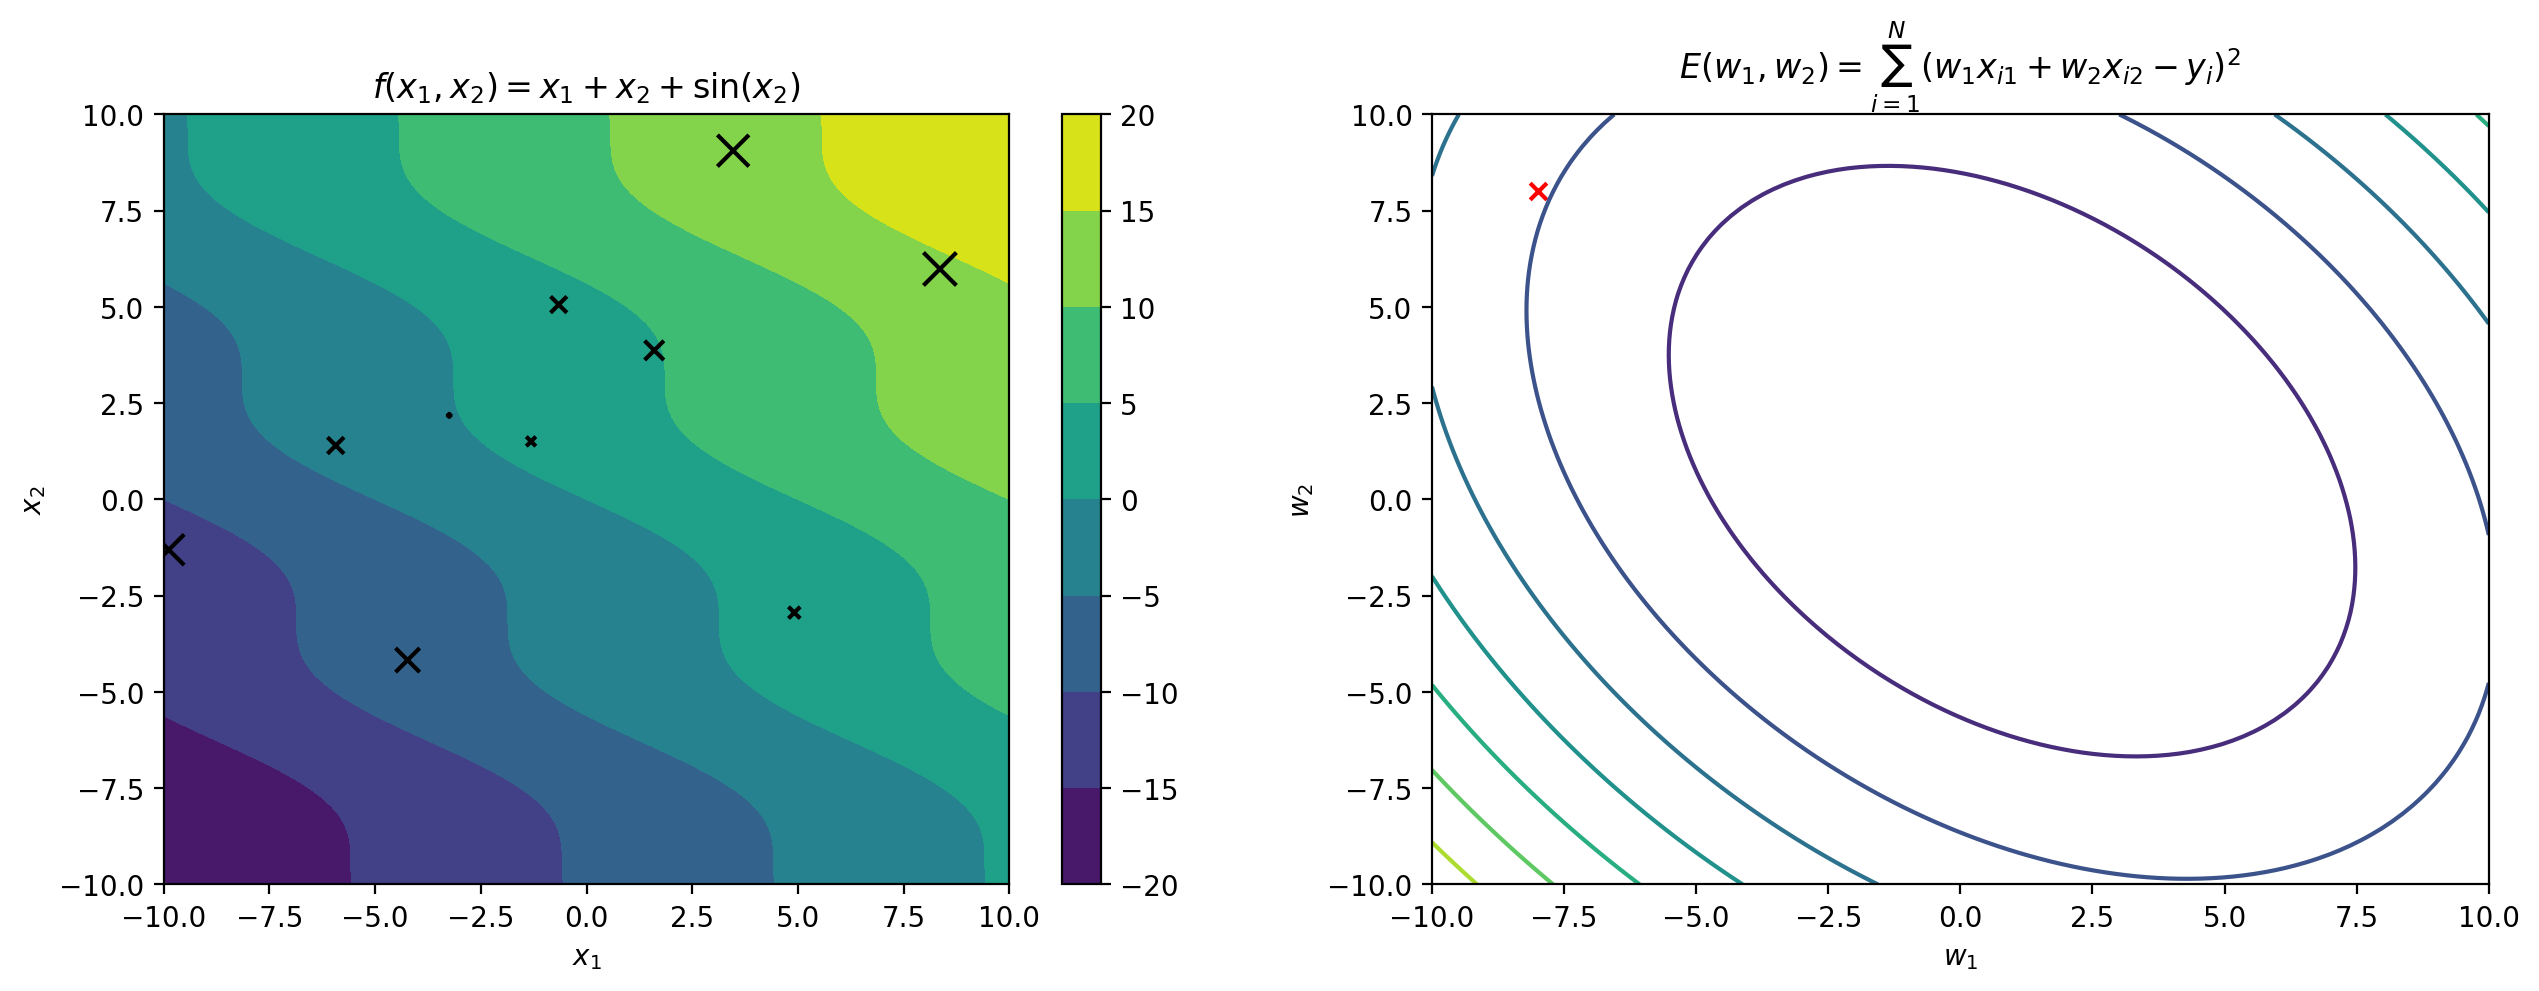

In [428]:
x = np.linspace(-10, 10, 100)
x1, x2 = np.meshgrid(x, x)

f = lambda x1, x2:  x1 + x2 + np.sin(x2)

x_sample = np.random.uniform(-10, 10, (10, 2))
y_sample = f(x_sample[:, 0], x_sample[:, 1])

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.contourf(x1, x2, f(x1, x2)); plt.colorbar()
plt.scatter(x_sample[:, 0], x_sample[:, 1], np.abs(y_sample * 10), color="black", marker="x")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("$f(x_1, x_2) = x_1 + x_2 + \sin(x_2)$")

w_init = np.array([-8, 8])
w = np.linspace(-10, 10, 100)
w1, w2 = np.meshgrid(w, w)

error = np.sum((w1.reshape(-1, 1) * x_sample[:, 0] + w2.reshape(-1, 1) * x_sample[:, 1] - y_sample)**2, axis=1).reshape(100, 100)

plt.subplot(1, 2, 2)
plt.contour(w1, w2, error)
plt.scatter(*w_init, color="red", marker="x")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("$E(w_1, w_2) = \sum_{i=1}^N (w_1x_{i1} + w_2x_{i2} - y_i)^2$")

plt.show()

Then, given a starting point in the error function (depicted by the red cross), gradient descent incrementally moves towards the optimal solution, since the error function is convex. However, keep in mind, that in a neural network the error function is **non-convex** and thus, there are multiple local optima. The following figures present the path followed by the batch gradient descent, SDG and mini-batch SDG to arrive to the optima of the sum of squared error function.

Batch gradient descent seems to move directly towards the optimal solution without fluctuations. However, since it requires the entire dataset to be loaded in memory it may become slow as the training dataset size increases. In a toy dataset, there is no such issue of course, but in real-world problems the issue is very common. On the other hand, SGD processes one example in every iteration, making training efficient in terms of memory, but there are fluctuations across iterations. Mini-batch gradient descent lies in-between. It does not fluctuate a lot across iterations, and it operates in a online fashion using a batch of data per iteration instead, thus avoiding memory problems. Moreover, mini-batch gradient descent is also much more efficient than SDG because it gains significant speedups from vectorization operations.

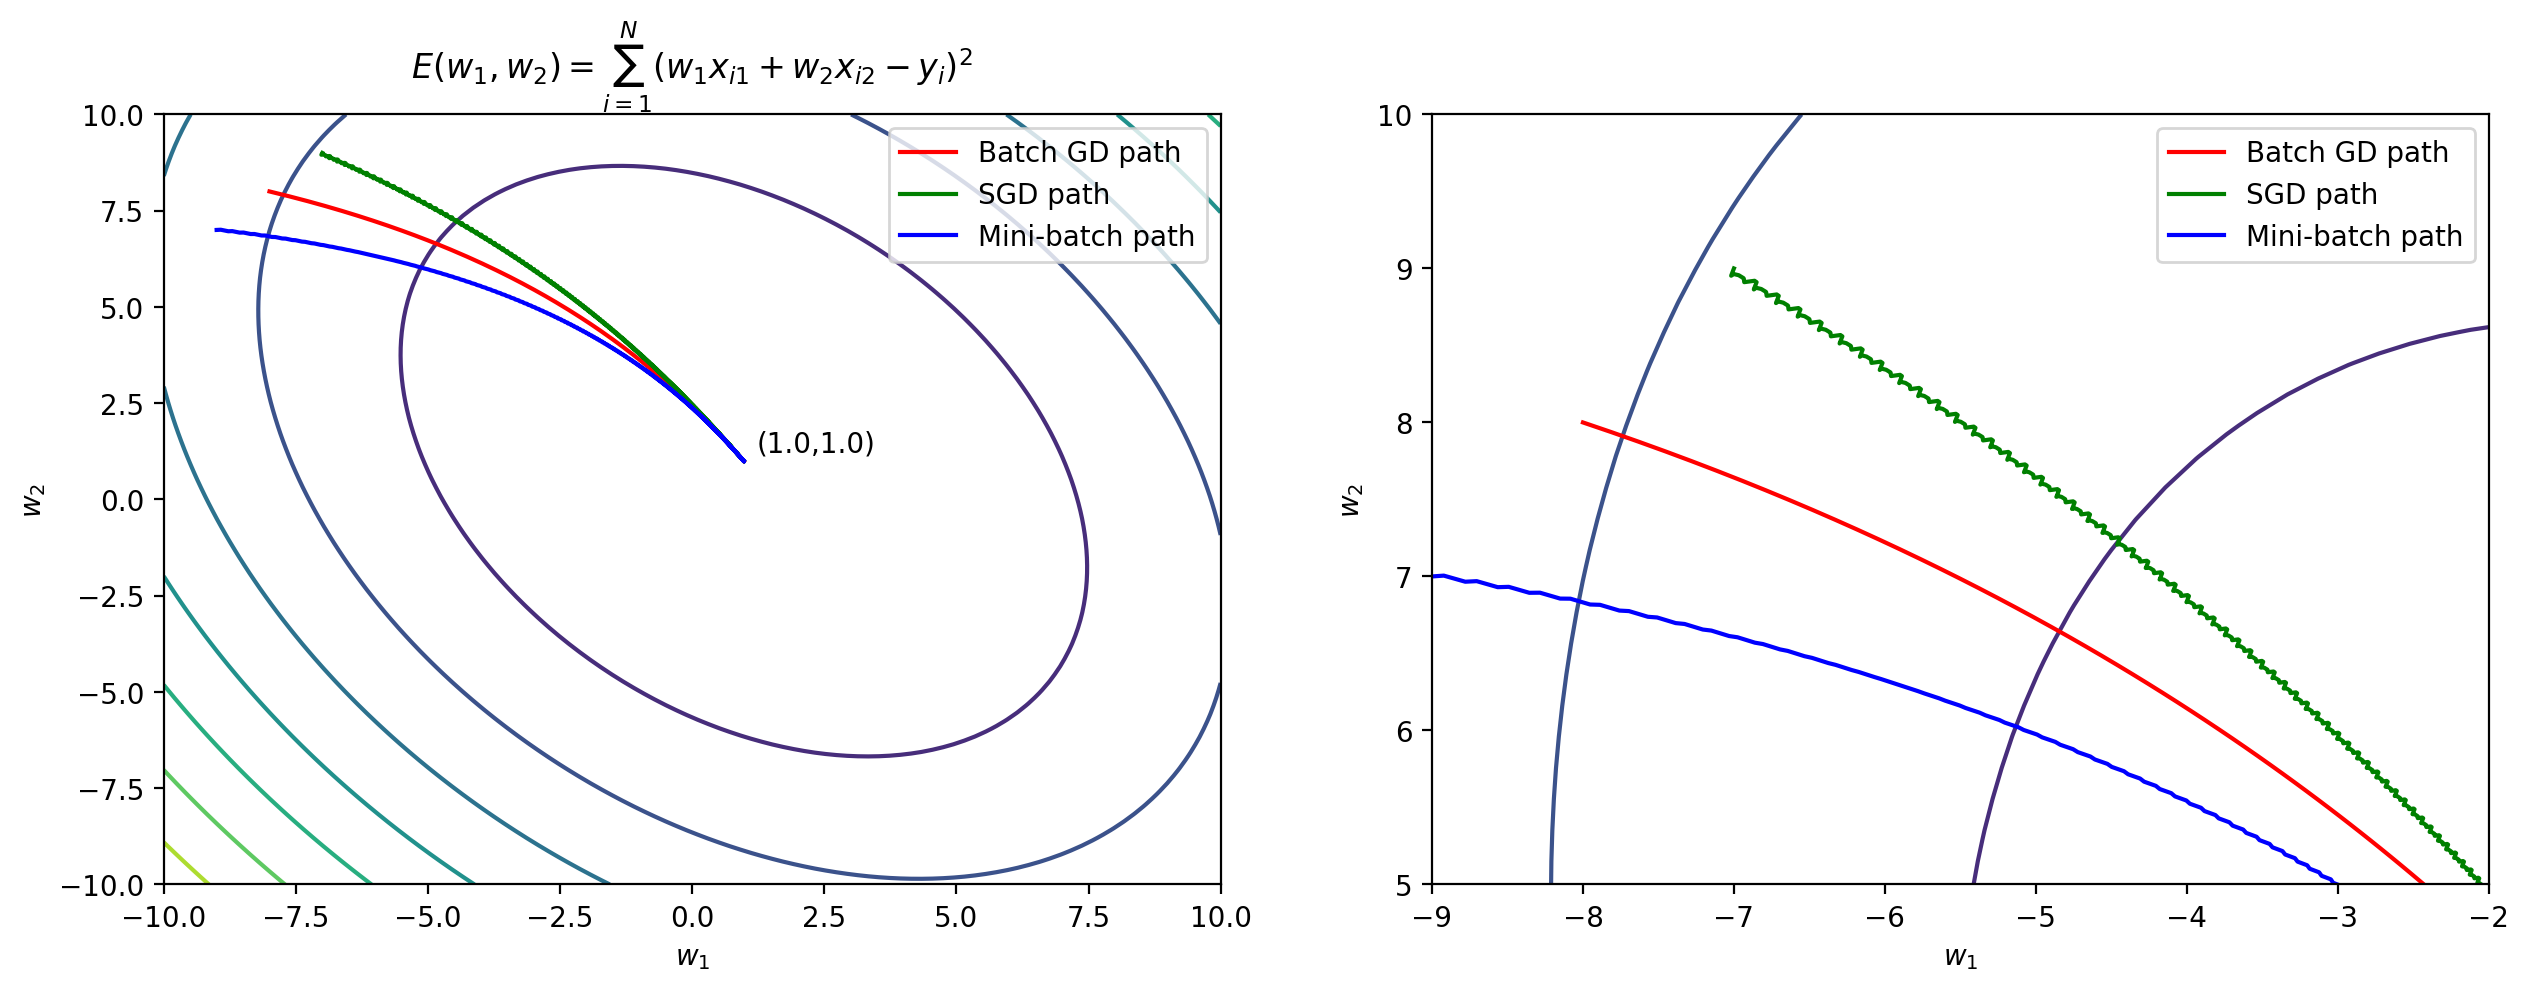

In [432]:
def error_gradient(w1, w2, x, y):
    if x.ndim == 1:
        return np.array([(w1 * x[0] + w2 * x[1] - y) * x[0], (w1 * x[0] + w2 * x[1] - y) * x[1]]).T
    else:
        return np.array([(w1 * x[:, 0] + w2 * x[:, 1] - y) * x[:, 0], (w1 * x[:, 0] + w2 * x[:, 1] - y) * x[:, 1]]).T.sum(axis=0)

n_epochs = 1000
batch_gd_path, sgd_path, mini_batch_gd = [w_init], [w_init + 1], [w_init - 1]

# batch gradient descent
w_optimal = batch_gd_path[0]
for _ in range(n_epochs):
    w_optimal = w_optimal - 0.0001 * error_gradient(w_optimal[0], w_optimal[1], x_sample, y_sample)
    batch_gd_path.append(w_optimal)

# stochastic gradient descent
w_optimal = sgd_path[0]
for _ in range(n_epochs):
    for i in range(x_sample.shape[0]):
        w_optimal = w_optimal - 0.0001 * error_gradient(w_optimal[0], w_optimal[1], x_sample[i, :], y_sample[i])
        sgd_path.append(w_optimal)

# mini-batch gradient descent
w_optimal = mini_batch_gd[0]
mini_batches_x = np.split(x_sample, 2)
mini_batches_y = np.split(y_sample, 2)
for _ in range(n_epochs):
    for i in range(len(mini_batches_x)):
        w_optimal = w_optimal - 0.0001 * error_gradient(w_optimal[0], w_optimal[1], mini_batches_x[i], mini_batches_y[i])
        mini_batch_gd.append(w_optimal)

batch_gd_path = np.array(batch_gd_path)
sgd_path = np.array(sgd_path)
mini_batch_gd = np.array(mini_batch_gd)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.contour(w1, w2, error)
plt.plot(batch_gd_path[:, 0], batch_gd_path[:, 1], color="r", markersize=3)
plt.plot(sgd_path[:, 0], sgd_path[:, 1], color="g")
plt.plot(mini_batch_gd[:, 0], mini_batch_gd[:, 1], color="b")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.title("$E(w_1, w_2) = \sum_{i=1}^N (w_1x_{i1} + w_2x_{i2} - y_i)^2$")
plt.legend(["Batch GD path", "SGD path", "Mini-batch path"])
plt.annotate(text=f"({round(batch_gd_path[-1][0], 1)},{round(batch_gd_path[-1][1], 1)})", xy=batch_gd_path[-1], xytext=batch_gd_path[-1] + 0.25)

plt.subplot(1, 2, 2)
plt.contour(w1, w2, error)
plt.plot(batch_gd_path[:, 0], batch_gd_path[:, 1], color="r", markersize=3)
plt.plot(sgd_path[:, 0], sgd_path[:, 1], color="g")
plt.plot(mini_batch_gd[:, 0], mini_batch_gd[:, 1], color="b")
plt.xlabel("$w_1$")
plt.ylabel("$w_2$")
plt.legend(["Batch GD path", "SGD path", "Mini-batch path"])
plt.xlim(-9, -2)
plt.ylim(5, 10)

plt.show()

##### Challenges

1. Choosing a proper learning rate can be cumbersome. A learning rate that is too small leads slow convergence, while a learning rate that is too large can hinder convergence and cause the loss function to fluctuate around the minimum or even to diverge.

2. Learning rate schedules try to adjust the learning rate during training by e.g., annealing, that is, reducing the learning rate according to a pre-defined schedule or when the change in objective between epochs falls below a threshold. These schedules and thresholds, however, have to be determined in advance and are unable to adapt to dataset's characteristics.

3. Learning rate applies horizontally to all parameter updates. If the data is sparse and the features have very different frequencies, we might not want to update all of them to the same extent, but instead, perform larger updates for rarely occurring features.

4. Another key challenge of minimizing highly non-convex error functions, which is common for neural networks, is avoiding getting trapped in their numerous suboptimal local minima. This difficulty arises from saddle points, i.e., points where one dimension slopes up and another slopes down. These saddle points are usually surrounded by a plateau of the same error, which makes it notoriously hard for SGD to escape, as the gradient is close to zero in all dimensions.

#### Momentum

SGD has trouble navigating areas where the surface curves much more steeply in one dimension than in another, which are common around local optima. In these scenarios, SGD oscillates across the slopes of the area while only making hesitant progress along the bottom towards the local optimum. *Momentum* is a method that helps accelerate SGD in the relevant direction and dampens oscillations. It achieves this by adding a fraction $\gamma$ of the update vector of the past update step to the current update vector as follows,

$$
\begin{aligned}
\mathbf{u}_{\tau} &= \gamma\mathbf{u}_{\tau-1} + \eta\nabla E(\mathbf{w};\mathbf{X}_{i:i+n};\mathbf{y}_{i:i+n})\\
\mathbf{w} &= \mathbf{w} - \mathbf{u}_{\tau}
\end{aligned}
$$

where the momentum term $\gamma$ is usually set to $0.9$ or a similar value. Intuitively, when using momentum, we push a ball down the hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way. The parameter $\gamma < 1$ plays the role of air resistance. The same thing happens to our parameter updates. The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation.